In [1]:
#last chapter, chapter 11, virtual screening

In [2]:
#A Virtual Screening Workflow Example

In [3]:
#a set of
# molecules known to bind to a particular protein, as well as a set of molecules assumed
# to not bind, to train a convolutional neural network to identify new molecules with
# the potential to bind to the target

In [4]:
# ERK2 MAPK1 same protein, involved in signalling

In [5]:
#We will train the model to distinguish a set of ERK2 active compounds from a set of
#decoy compounds. The active and decoy compounds are derived from the DUD-E
#database, which is designed for testing predictive models

In [6]:
##setup tensorflow v1
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [7]:
!wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
!chmod +x Anaconda3-2019.10-Linux-x86_64.sh
!bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-07-28 10:08:01--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M  69.1MB/s    in 7.6s    

2020-07-28 10:08:09 (66.6 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navigator==1.9.7=py37_0
    - anaconda-p

In [8]:

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
active_df = pd.read_csv("actives_final.ism",header=None,sep=" ")
active_rows,active_cols = active_df.shape
active_df.columns = ["SMILES","ID","ChEMBL_ID"]
active_df["label"] = ["Active"]*active_rows
PandasTools.AddMoleculeColumnToFrame(active_df,"SMILES","Mol")

In [10]:
def add_property_columns_to_df(df_in):
    df_in["mw"] = [Descriptors.MolWt(mol) for mol in df_in.Mol]
    df_in["logP"] = [Descriptors.MolLogP(mol) for mol in df_in.Mol]
    df_in["charge"] = [rdmolops.GetFormalCharge(mol) for mol in df_in.Mol]

In [11]:
add_property_columns_to_df(active_df)

,SMILES,ID,ChEMBL_ID,label,Mol,mw,logP,charge
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,CHEMBL318804,Active,,565.099,5.49788,0
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,CHEMBL162,Active,,466.541,4.35400,0
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,CHEMBL576683,Active,,527.915,4.96202,0
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,CHEMBL571484,Active,,491.935,4.36922,0
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,CHEMBL568937,Active,,487.991,5.12922,0

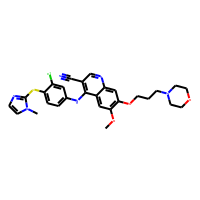
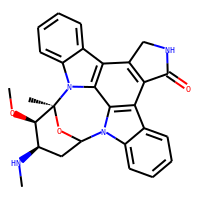
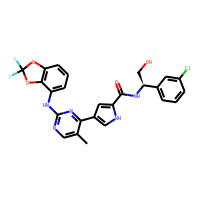
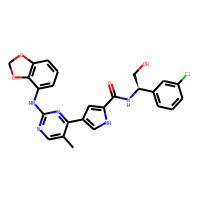
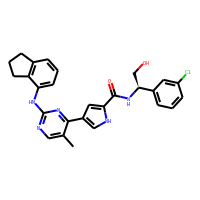

In [12]:
active_df.head()

In [13]:
decoy_df = pd.read_csv("decoys_final.ism",header=None,sep=" ")
decoy_df.columns = ["SMILES","ID"]
decoy_rows, decoy_cols = decoy_df.shape
decoy_df["label"] = ["Decoy"]*decoy_rows
PandasTools.AddMoleculeColumnToFrame(decoy_df,"SMILES","Mol")
add_property_columns_to_df(decoy_df)

,SMILES,ID,label,Mol,mw,logP,charge
0,C1COCCNC(=S)NCCOCCNC(=S)N1,C03897368,Decoy,,292.430,-1.03860,0
1,c1cc(ccc1[C@H]2c3ccc(cc3OC(=C2C#N)N)N)O,C00242247,Decoy,,279.299,2.19258,0
2,C[C@]12CC[C@H](C[C@@H]1CC[C@@H]3[C@@H]2C(=O)C[...,C04096778,Decoy,,366.498,1.65330,0
3,Cc1ccc2c(c1)cc(c(=O)[nH]2)[C@@H]3c4c(n[nH]c4OC...,C00421469,Decoy,,333.351,2.08622,0
4,Cc1cc2cc(c(=O)[nH]c2cc1C)[C@@H]3c4c(n[nH]c4OC(...,C00421479,Decoy,,347.378,2.39464,0

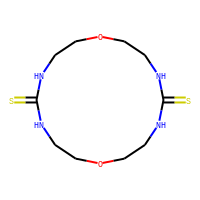
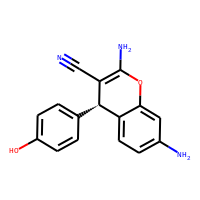
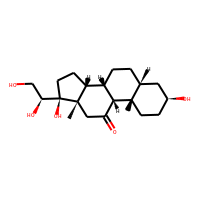
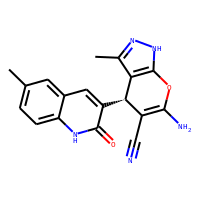
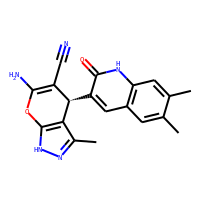

In [14]:
decoy_df.head()

In [15]:
tmp_df = active_df.append(decoy_df)

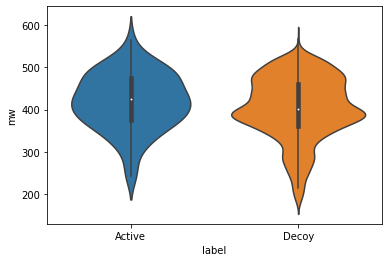

In [16]:
sns.violinplot(tmp_df["label"],tmp_df["mw"])

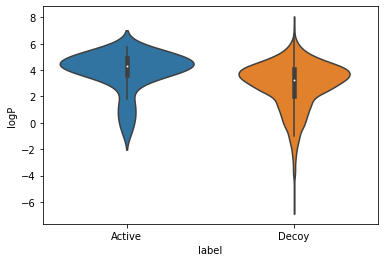

In [17]:
sns.violinplot(tmp_df["label"],tmp_df["logP"])

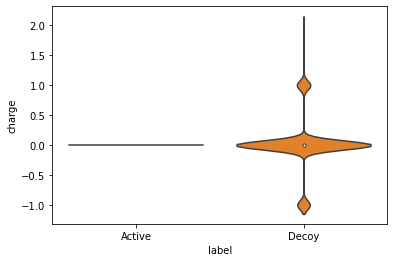

In [18]:
sns.violinplot(tmp_df["label"],tmp_df["charge"])

In [19]:
charged = decoy_df[decoy_df["charge"] != 0]

In [20]:
charged.shape[0]/decoy_df.shape[0]

0.16175824175824177

In [21]:
from neutralize import NeutraliseCharges

In [22]:
revised_decoy_df = decoy_df[["SMILES","ID","label"]].copy()

In [23]:

revised_decoy_df["SMILES"] = [NeutraliseCharges(x)[0] for x in revised_decoy_df["SMILES"]]

In [24]:
PandasTools.AddMoleculeColumnToFrame(revised_decoy_df,"SMILES","Mol")
add_property_columns_to_df(revised_decoy_df)

In [25]:
new_tmp_df = active_df.append(revised_decoy_df)

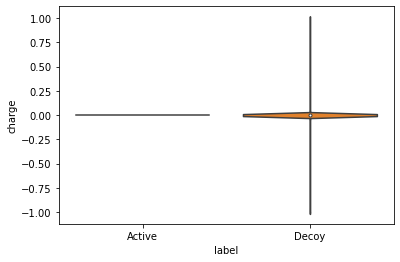

In [26]:
sns.violinplot(new_tmp_df["label"],new_tmp_df["charge"])

In [27]:
charged = revised_decoy_df[revised_decoy_df["charge"] != 0]
charged.shape[0]/revised_decoy_df.shape[0]

0.0026373626373626374

In [28]:

active_df["is_active"] = [1] * active_df.shape[0]
revised_decoy_df["is_active"] = [0] * revised_decoy_df.shape[0]
combined_df = active_df.append(revised_decoy_df)[["SMILES","ID","is_active"]]
combined_df.head()

,SMILES,ID,is_active
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,1
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,1
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,1
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,1
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,1


In [29]:
combined_df.to_csv("dude_erk1_mk01.csv")

In [30]:
#part1 over 

In [31]:
#part 2 training a predictive model

In [32]:

import deepchem as dc
from deepchem.models import GraphConvModel
import numpy as np
import sys
import pandas as pd
import seaborn as sns
from rdkit.Chem import PandasTools

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [33]:
def generate_graph_conv_model():
    batch_size = 128
    model = GraphConvModel(1, batch_size=batch_size, mode='classification',model_dir="./model_dir")
    return model

In [35]:
dataset_file = "dude_erk2_mk01.csv"
tasks = ["is_active"]
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, smiles_field="SMILES", featurizer=featurizer)
dataset = loader.featurize(dataset_file, shard_size=8192)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from dude_erk2_mk01.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
TIMING: featurizing shard 0 took 13.727 s
TIMING: dataset construction took 15.595 s
Loading dataset from disk.


In [36]:
splitter = dc.splits.RandomSplitter()

In [37]:
metrics = [dc.metrics.Metric(dc.metrics.matthews_corrcoef, np.mean, mode="classification")]

In [38]:
training_score_list = []
validation_score_list = []
transformers = []
cv_folds = 10
for i in range(0,cv_folds):
    model = generate_graph_conv_model()
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
    model.fit(train_dataset)
    train_scores = model.evaluate(train_dataset, metrics, transformers)
    training_score_list.append(train_scores["mean-matthews_corrcoef"])
    validation_scores = model.evaluate(valid_dataset, metrics, transformers)
    validation_score_list.append(validation_scores["mean-matthews_corrcoef"])
print(training_score_list)
print(validation_score_list)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


TIMING: dataset construction took 2.295 s
Loading dataset from disk.
TIMING: dataset construction took 0.939 s
Loading dataset from disk.
TIMING: dataset construction took 0.939 s
Loading dataset from disk.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.9460858016837398]
computed_metrics: [0.5435391270264687]
TIMING: dataset construction took 2.262 s
Loading dataset from disk.
TIMING: dataset construction took 1.000 s
Loading dataset from disk.
TIMING: dataset construction took 0.997 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.9552702926783022]
computed_metrics: [0.8339033138452595]
TIMING: dataset construction took 2.219 s
Loading dataset from disk.
TIMING: dataset construction took 1.025 s
Loading dataset from disk.
TIMING: dataset construction took 0.814 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.7655981029166788]
computed_metrics: [0.8924592520017463]
TIMING: dataset construction took 2.216 s
Loading dataset from disk.
TIMING: dataset construction took 1.048 s
Loading dataset from disk.
TIMING: dataset construction took 1.044 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.7676840845478065]
computed_metrics: [0.8924592520017463]
TIMING: dataset construction took 2.283 s
Loading dataset from disk.
TIMING: dataset construction took 0.827 s
Loading dataset from disk.
TIMING: dataset construction took 1.061 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.7757311284053034]
computed_metrics: [0.9118738006098865]
TIMING: dataset construction took 2.328 s
Loading dataset from disk.
TIMING: dataset construction took 0.819 s
Loading dataset from disk.
TIMING: dataset construction took 1.088 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.876094368390309]
computed_metrics: [0.7032364358565029]
TIMING: dataset construction took 2.034 s
Loading dataset from disk.
TIMING: dataset construction took 1.105 s
Loading dataset from disk.
TIMING: dataset construction took 1.126 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.8551383428557057]
computed_metrics: [0.8924592520017463]
TIMING: dataset construction took 2.031 s
Loading dataset from disk.
TIMING: dataset construction took 1.156 s
Loading dataset from disk.
TIMING: dataset construction took 1.162 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.9474286308512249]
computed_metrics: [0.8311451495258935]
TIMING: dataset construction took 2.371 s
Loading dataset from disk.
TIMING: dataset construction took 0.827 s
Loading dataset from disk.
TIMING: dataset construction took 1.178 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.956770751260633]
computed_metrics: [0.8499867778251156]
TIMING: dataset construction took 2.339 s
Loading dataset from disk.
TIMING: dataset construction took 0.839 s
Loading dataset from disk.
TIMING: dataset construction took 1.182 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.6443982521347705]
computed_metrics: [0.9118738006098865]
[0.9460858016837398, 0.9552702926783022, 0.7655981029166788, 0.7676840845478065, 0.7757311284053034, 0.876094368390309, 0.8551383428557057, 0.9474286308512249, 0.956770751260633, 0.6443982521347705]
[0.5435391270264687, 0.8339033138452595, 0.8924592520017463, 0.8924592520017463, 0.9118738006098865, 0.7032364358565029, 0.8924592520017463, 0.8311451495258935, 0.8499867778251156, 0.9118738006098865]


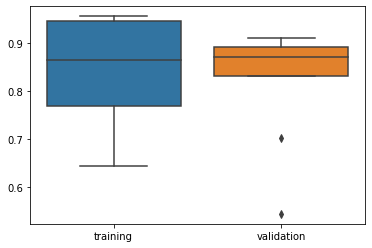

In [39]:
sns.boxplot(["training"]*cv_folds+["validation"]*cv_folds,training_score_list+validation_score_list)

In [40]:

pred = [x.flatten() for x in model.predict(valid_dataset)]

In [41]:
pred_df = pd.DataFrame(pred,columns=["neg","pos"])

In [42]:

pred_df["active"] = [int(x) for x in valid_dataset.y]
pred_df["SMILES"] = valid_dataset.ids

In [43]:
pred_df.head()

,neg,pos,active,SMILES
0,0.998102,0.001898,1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...
1,0.201801,0.798199,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...
2,0.324161,0.675839,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3ccccc3)...
3,0.434926,0.565074,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3ccccc3)...
4,0.216482,0.783518,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...


In [44]:
pred_df.sort_values("pos",ascending=False).head(25)

,neg,pos,active,SMILES
1,0.201801,0.798199,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...
4,0.216482,0.783518,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...
5,0.247281,0.752719,1,c1cc(cc(c1)Cl)c2cn[nH]c2c3cc([nH]c3)C(=O)NC(CO...
2,0.324161,0.675839,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3ccccc3)...
3,0.434926,0.565074,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3ccccc3)...
36,0.826284,0.173716,0,c1c(cc(cc1Cl)Cl)n2c3c(cn2)c(ncn3)NN
265,0.918809,0.081191,0,c1ccc2c(c1)c(nc(n2)c3ccncc3)N4CCO[C@@H](C4)c5c...
398,0.937730,0.062270,0,CCc1c(c(c(c(c1)CC)/C(=N\O)/Nc2ccccc2)CC)/C(=N\...
259,0.952813,0.047187,0,CCN[C@H](c1cccs1)c1cc2[nH]c(=O)[nH]c2cc1Br
24,0.963226,0.036774,0,CN(C)c1ccc(cc1)[C@H]2C(=C(NC(=O)N2)c3ccccc3)c4...


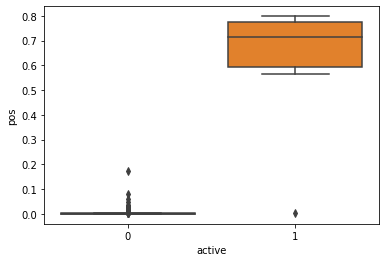

In [45]:
sns.boxplot(pred_df.active,pred_df.pos)

In [46]:
false_negative_df = pred_df.query("active == 1 & pos < 0.5").copy()

In [47]:
PandasTools.AddMoleculeColumnToFrame(false_negative_df,"SMILES","Mol")

,neg,pos,active,SMILES,Mol
0,0.998102,0.001898,1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,

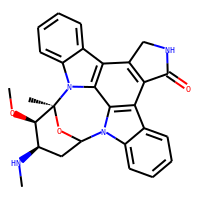

In [48]:

false_negative_df

In [49]:
false_positive_df = pred_df.query("active == 0 & pos > 0.5").copy()
PandasTools.AddMoleculeColumnToFrame(false_positive_df,"SMILES","Mol")

In [50]:
false_positive_df

,neg,pos,active,SMILES,Mol


In [51]:
model.fit(dataset)

0.002604673918055293

In [52]:
#part 2 over part 3 begin

In [54]:
#install rd_filters for the 3rd part
!pip install git+https://github.com/PatWalters/rd_filters.git

  Cloning https://github.com/PatWalters/rd_filters.git to /tmp/pip-req-build-np6njoo2
  Running command git clone -q https://github.com/PatWalters/rd_filters.git /tmp/pip-req-build-np6njoo2
  Created wheel for rd-filters: filename=rd_filters-0.1-cp37-none-any.whl size=33802 sha256=e577eb1b060e9a31250d946c415bea089f5c898487c44a32248fa392c5f633a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-5s_es2mk/wheels/d4/87/35/cd3956abaa31773a068c13c51f929aabe700118852e72bb3ca
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=a32ae05dad92395a55429ef1e1597f9caa59ca5f1d88bb442d984c735ae4d665
  Stored in directory: /root/.cache/pip/wheels/9b/04/dd/7daf4150b6d9b12949298737de9431a324d4b797ffd63f526e
Successfully built rd-filters docopt


In [55]:
!rd_filters -h

Usage:
rd_filters filter --in INPUT_FILE --prefix PREFIX [--rules RULES_FILE_NAME] [--alerts ALERT_FILE_NAME][--np NUM_CORES]
rd_filters template --out TEMPLATE_FILE [--rules RULES_FILE_NAME]

Options:
--in INPUT_FILE input file name
--prefix PREFIX prefix for output file names
--rules RULES_FILE_NAME name of the rules JSON file
--alerts ALERTS_FILE_NAME name of the structural alerts file
--np NUM_CORES the number of cpu cores to use (default is all)
--out TEMPLATE_FILE parameter template file name


In [56]:
!rd_filters filter --in zinc_100k.smi --prefix zinc

using 2 cores
Using alerts from Inpharmatica
Wrote SMILES for molecules passing filters to zinc.smi
Wrote detailed data to zinc.csv
68410 of 100000 passed filters 68.4%
Elapsed time 83.61 seconds


In [57]:
df = pd.read_csv("zinc.csv")

In [58]:

df.head()

,SMILES,NAME,FILTER,MW,LogP,HBD,HBA,TPSA,Rot
0,CN(CCO)C[C@@H](O)Cn1cnc2c1c(=O)n(C)c(=O)n2C,ZINC000000000843,Filter82_pyridinium > 0,311.342,-2.2813,2,9,105.52,6
1,O=c1[nH]c(=O)n([C@@H]2C[C@@H](O)[C@H](CO)O2)cc1Br,ZINC000000001063,Filter9_metal > 0,307.100,-1.0602,3,6,104.55,2
2,Cn1c2ncn(CC(=O)N3CCOCC3)c2c(=O)n(C)c1=O,ZINC000000003942,Filter82_pyridinium > 0,307.310,-1.7075,0,8,91.36,2
3,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,OK,308.382,-1.0163,0,5,64.17,3
4,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,OK,302.327,-1.1355,3,6,106.12,4


In [59]:
from collections import Counter
count_list = list(Counter(df.FILTER).items())
count_df = pd.DataFrame(count_list,columns=["Rule","Count"])
count_df.sort_values("Count",inplace=True,ascending=False)
count_df.head()

,Rule,Count
2,OK,69148
7,Filter41_12_dicarbonyl > 0,19330
0,Filter82_pyridinium > 0,7713
11,Filter93_acetyl_urea > 0,1541
12,Filter78_bicyclic_Imide > 0,825


In [60]:
smiles_list = df[df.FILTER == "Filter41_12_dicarbonyl > 0"].SMILES[:10]

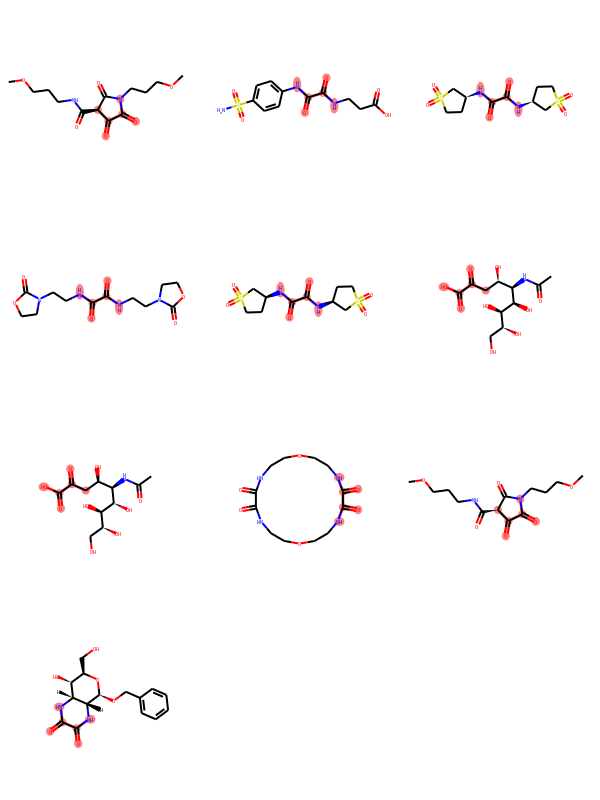

In [62]:
from rdkit import Chem
from rdkit.Chem import Draw

mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
dicarbonyl = Chem.MolFromSmarts('*C(=O)C(=O)*')
match_list = [mol.GetSubstructMatch(dicarbonyl) for mol in mol_list]
Draw.MolsToGridImage(mol_list,highlightAtomLists=match_list,molsPerRow=3)

In [63]:
#part 3 over , starting part 4

In [64]:
import deepchem as dc
import pandas as pd
from rdkit.Chem import PandasTools, Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
import seaborn as sns

In [65]:

model = dc.models.GraphConvModel(1, batch_size=128, mode='classification',model_dir="model_dir")
model.restore()

In [66]:
featurizer = dc.feat.ConvMolFeaturizer()

In [67]:
df = pd.read_csv("zinc.smi",sep=" ",header=None)

In [68]:
df.columns=["SMILES","Name"]

In [69]:
rows,cols = df.shape
df["Val"] = [0] * rows

In [70]:
df.head()

,SMILES,Name,Val
0,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,0
1,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,0
2,C1CN(c2nc(-c3nn[nH]n3)nc(N3CCOCC3)n2)CCO1,ZINC000000054542,0
3,OCCN(CCO)c1nc(Cl)nc(N(CCO)CCO)n1,ZINC000000109481,0
4,COC(=O)c1ccc(S(=O)(=O)N(CCO)CCO)n1C,ZINC000000119782,0


In [71]:
infile_name = "zinc_filtered.csv"
df.to_csv(infile_name,index=False)

In [72]:
loader = dc.data.CSVLoader(tasks=['Val'], smiles_field="SMILES", featurizer=featurizer)

In [73]:
dataset = loader.featurize(infile_name, shard_size=8192)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from zinc_filtered.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 0 took 22.416 s
Loading shard 2 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 1 took 21.938 s
Loading shard 3 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 2 took 22.631 s
Loading shard 4 of size 8192.
Featurizing sample 0
Fe

In [74]:
pred = model.predict(dataset)

In [75]:

pred_df = pd.DataFrame([x.flatten() for x in pred],columns=["Neg","Pos"])

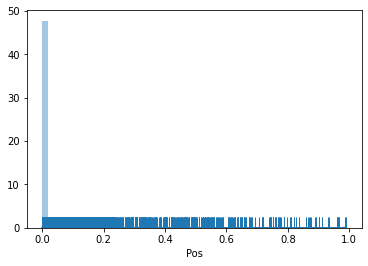

In [76]:
sns.distplot(pred_df.Pos,rug=True)

In [77]:
combo_df = df.join(pred_df,how="outer")

In [78]:
combo_df.sort_values("Pos",inplace=True,ascending=False)

In [79]:
PandasTools.AddMoleculeColumnToFrame(combo_df,"SMILES","Mol")

,SMILES,Name,Val,Neg,Pos,Mol
54838,Cn1cncc1C(=O)NC[C@@H](CO)NC(=O)c1cncn1C,ZINC000644062250,0,0.009582,0.990418,
41361,CN(C)c1cnc(C(=O)N[C@H](CO)CN2CCOCC2)cn1,ZINC000580845139,0,0.012536,0.987464,
41360,CN(C)c1cnc(C(=O)N[C@@H](CO)CN2CCOCC2)cn1,ZINC000580845134,0,0.012536,0.987464,
12624,Cn1nnc2cc(C(=O)N[C@@H](CO)CN3CCOCC3)cnc21,ZINC000339212693,0,0.033122,0.966878,
12625,Cn1nnc2cc(C(=O)N[C@H](CO)CN3CCOCC3)cnc21,ZINC000339212694,0,0.033122,0.966878,

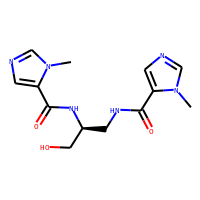
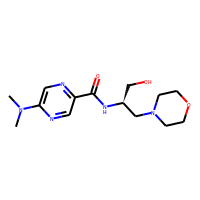
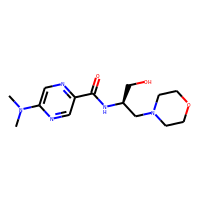
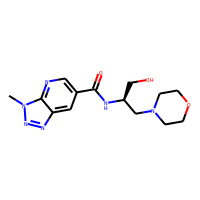
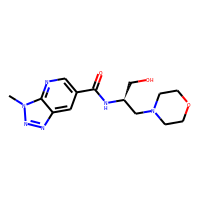

In [80]:
combo_df.head()

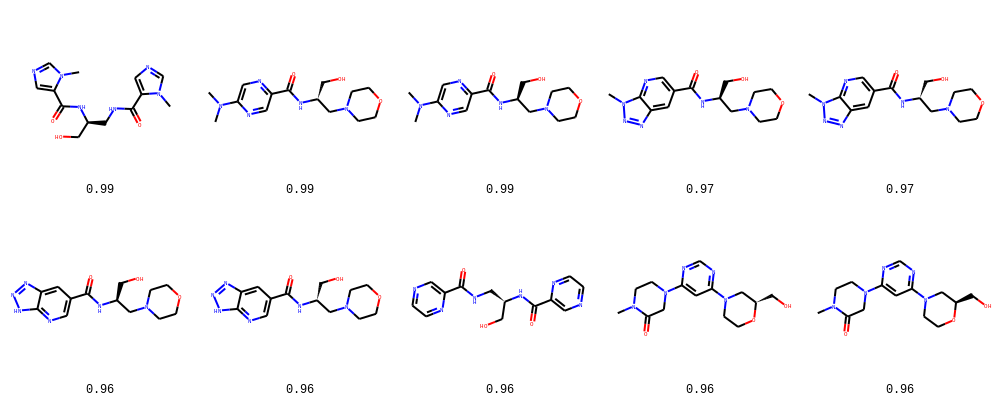

In [81]:
Draw.MolsToGridImage(combo_df.Mol[:10],molsPerRow=5,legends=["%.2f" % x for x in combo_df.Pos[:10]])

In [82]:
def butina_cluster(mol_list,cutoff=0.35):
    fp_list = [rdmd.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mol_list]
    dists = []
    nfps = len(fp_list)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        dists.extend([1-x for x in sims])
    mol_clusters = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    cluster_id_list = [0]*nfps
    for idx,cluster in enumerate(mol_clusters,1):
        for member in cluster:
            cluster_id_list[member] = idx
    return cluster_id_list

In [83]:
best_100_df = combo_df.head(100).copy()

In [84]:
best_100_df["Cluster"] = butina_cluster(best_100_df.Mol)

,SMILES,Name,Val,Neg,Pos,Mol,Cluster
54838,Cn1cncc1C(=O)NC[C@@H](CO)NC(=O)c1cncn1C,ZINC000644062250,0,0.009582,0.990418,,59
41361,CN(C)c1cnc(C(=O)N[C@H](CO)CN2CCOCC2)cn1,ZINC000580845139,0,0.012536,0.987464,,5
41360,CN(C)c1cnc(C(=O)N[C@@H](CO)CN2CCOCC2)cn1,ZINC000580845134,0,0.012536,0.987464,,5
12624,Cn1nnc2cc(C(=O)N[C@@H](CO)CN3CCOCC3)cnc21,ZINC000339212693,0,0.033122,0.966878,,27
12625,Cn1nnc2cc(C(=O)N[C@H](CO)CN3CCOCC3)cnc21,ZINC000339212694,0,0.033122,0.966878,,27

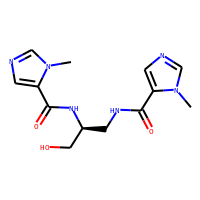
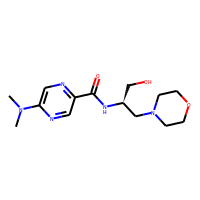
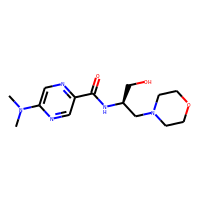
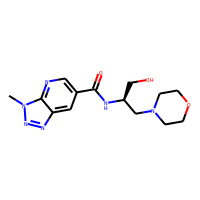
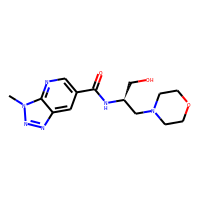

In [85]:
best_100_df.head()

In [86]:
len(best_100_df.Cluster.unique())

59

In [87]:
best_cluster_rep_df = best_100_df.drop_duplicates("Cluster")

In [89]:
best_cluster_rep_df.shape

(59, 7)

In [90]:
best_cluster_rep_df.to_csv("best_cluster_represenatives.csv")

In [94]:
#mols = best_cluster_rep_df.iloc[:,5]

In [96]:
#type(mols)

In [97]:
#chapter over